In [ ]:

# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import random
# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [5]:
# define different function
from sklearn.utils import shuffle

def LoadData(input,strain):
    df=pd.read_csv(input)
    df=shuffle(df)
    df_strain=df[(df['strain'] ==strain)]
    df_strain['y']= np.log(df_strain['Fitness'])
    train, test = np.split(df_strain, [int(.8*len(df_strain))])
    index = ['val']*int(round(len(train)*0.2)) + ['train']*int(round(len(train)*0.8))
    random.shuffle(index)
    train['set']=index
    train = train.reset_index()
    return train, test
def ProduceAA(num,length):
    AA=[]
    AA_ls='ACDEFGHIKLMNPQRSTVWY'
    for i in range(num):
        aa=''.join(random.choice(AA_ls) for x in range(length))
        AA.append(aa)
    AA = pd.Series(AA)
    return AA

def Train_model(train_set,test_set,reg,lr,batch):

    L = len(train_set.iloc[0,1])
    model = mavenn.Model(L=L,
                         alphabet='protein',
                         gpmap_type='pairwise',
                         regression_type='GE',
                         ge_noise_model_type='Gaussian',
                         eta_regularization=0.1,
                         theta_regularization=reg)
    # Set training data
    model.set_data(x=train_set["ID"],
                   y=train_set["y"],
                   validation_flags=(train_set['set']=='val'),
                   shuffle=True)

    # Fit model to data
    history = model.fit(learning_rate=lr,
                        epochs=1000,
                        batch_size=batch,
                        early_stopping=True,
                        early_stopping_patience=5,
                        linear_initialization=False)
    return model
def PlotTrain(model,test_set):
    # Get x and y
    x_test = test_set['ID'].values
    y_test = test_set['y'].values

    # Show training history
    print('On test data:')

    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')

    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']

    fig, ax = plt.subplots(1,2,figsize=[8,4])
    ax[0].plot(I_var_hist, label='I_var_train')
    ax[0].plot(val_I_var_hist, label='I_var_val')
    ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
    ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('bits')
    ax[0].set_title('training hisotry')
    ax[0].set_ylim([0, I_pred*1.2]);

    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

    plt.tight_layout()
    plt.show()
def PlotR2(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict measurement values (yhat) on test data
    yhat_test = model.x_to_yhat(x_test)
    # Compute R^2 between yhat and y_test
    Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

    # Plot y_test vs. yhat_test
    fig, ax = plt.subplots(1,1)
    ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.4, label='test data')
    ax.set_xlabel('model prediction ($\hat{y}$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title(f'performance ($R^2$={Rsq:.3})')
    plt.show()
def PlotGEnonlinearity(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict latent phentoype values (phi) on test data
    phi_test = model.x_to_phi(x_test)

    # Set phi lims and create grid in phi space
    phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

    # Compute yhat each phi gridpoint
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Compute 90% CI for each yhat
    q = [0.05, 0.95] #[0.16, 0.84]
    yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])

    # Illustrate measurement process with GE curve
    ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
    ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
            label='$\hat{y} = g(\phi)$')
    ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
    ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title('measurement process')
    ax.legend()

    # Fix up plot
    fig.tight_layout()
    plt.show()

#epi_map export
def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(6):
        for j in range(6):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map

#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df

def reformat(theta_lc):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    index=[156,158,159,190,193,196]
    theta_df = pd.DataFrame(theta_lc,index=index,columns=colnames)
    add_df = pd.DataFrame(columns=["pos","aa","add_fit"])
    for row_index, row in theta_df.iterrows():
        pos=row_index
        row=row.dropna()
        for col_index, col in row.items():
            add_fit=col
            aa=col_index
            add_row = [pos,aa,add_fit]
            add_series = pd.Series(add_row, index = add_df.columns)
            add_df = add_df.append(add_series,ignore_index=True)
    return add_df

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0183 sec.
Epoch 1/1000
6/6 [==============================] - 0s 31ms/step - loss: 242.8958 - I_var: -0.2101 - val_loss: 219.3965 - val_I_var: -0.1533
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 231.1417 - I_var: -0.1066 - val_loss: 210.6374 - val_I_var: -0.1008
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 222.2434 - I_var: -0.0563 - val_loss: 203.2487 - val_I_var: -0.0803
Epoch 4/1000
6/6 [==============================] - 0s 7ms/step - loss: 214.8186 - I_var: -0.0421 - val_loss: 196.5453 - val_I_var: -0.0710
Epoch 5/1000
6/6 [==============================] - 0s 7ms/step - loss: 208.1145 - I_var: -0.0337 - val_loss: 190.2939 - val_I_var: -0.0660
Epoch 6/1000
6/6 [==============================] - 0s 7ms/step - loss: 201.9585 - I_var: -0.0253 - val_loss: 184.3459 - val_I_var: -0.0610
Epoch 7/1000
6/6 [=========================

6/6 [==============================] - 0s 6ms/step - loss: 50.5071 - I_var: 1.1484 - val_loss: 46.3752 - val_I_var: 1.1274
Epoch 60/1000
6/6 [==============================] - 0s 7ms/step - loss: 49.4392 - I_var: 1.1623 - val_loss: 45.5251 - val_I_var: 1.1395
Epoch 61/1000
6/6 [==============================] - 0s 6ms/step - loss: 48.4588 - I_var: 1.1771 - val_loss: 44.7424 - val_I_var: 1.1488
Epoch 62/1000
6/6 [==============================] - 0s 6ms/step - loss: 47.5480 - I_var: 1.1906 - val_loss: 43.9106 - val_I_var: 1.1640
Epoch 63/1000
6/6 [==============================] - 0s 5ms/step - loss: 46.5645 - I_var: 1.2038 - val_loss: 43.1240 - val_I_var: 1.1775
Epoch 64/1000
6/6 [==============================] - 0s 6ms/step - loss: 45.6793 - I_var: 1.2170 - val_loss: 42.4489 - val_I_var: 1.1873
Epoch 65/1000
6/6 [==============================] - 0s 6ms/step - loss: 44.8619 - I_var: 1.2307 - val_loss: 41.8660 - val_I_var: 1.1958
Epoch 66/1000
6/6 [==============================] - 0s

6/6 [==============================] - 0s 6ms/step - loss: 18.4767 - I_var: 1.6676 - val_loss: 21.7014 - val_I_var: 1.5696
Epoch 119/1000
6/6 [==============================] - 0s 6ms/step - loss: 18.1667 - I_var: 1.6782 - val_loss: 21.7559 - val_I_var: 1.5737
Epoch 120/1000
6/6 [==============================] - 0s 5ms/step - loss: 17.6960 - I_var: 1.6880 - val_loss: 21.5318 - val_I_var: 1.5776
Epoch 121/1000
6/6 [==============================] - 0s 6ms/step - loss: 17.5193 - I_var: 1.6932 - val_loss: 21.2227 - val_I_var: 1.5843
Epoch 122/1000
6/6 [==============================] - 0s 6ms/step - loss: 17.1408 - I_var: 1.7004 - val_loss: 21.1786 - val_I_var: 1.5848
Epoch 123/1000
6/6 [==============================] - 0s 6ms/step - loss: 16.7572 - I_var: 1.7044 - val_loss: 21.1523 - val_I_var: 1.5864
Epoch 124/1000
6/6 [==============================] - 0s 6ms/step - loss: 16.4564 - I_var: 1.7100 - val_loss: 21.3271 - val_I_var: 1.5886
Epoch 125/1000
6/6 [=============================

Epoch 178/1000
6/6 [==============================] - 0s 6ms/step - loss: 4.4191 - I_var: 1.9649 - val_loss: 14.9256 - val_I_var: 1.7510
Epoch 179/1000
6/6 [==============================] - 0s 6ms/step - loss: 4.5021 - I_var: 1.9615 - val_loss: 15.2228 - val_I_var: 1.7505
Epoch 180/1000
6/6 [==============================] - 0s 5ms/step - loss: 4.2521 - I_var: 1.9619 - val_loss: 14.8242 - val_I_var: 1.7583
Training time: 8.6 seconds
On test data:
I_var_test: 1.760 +- 0.103 bits
I_pred_test: 1.851 +- 0.102 bits


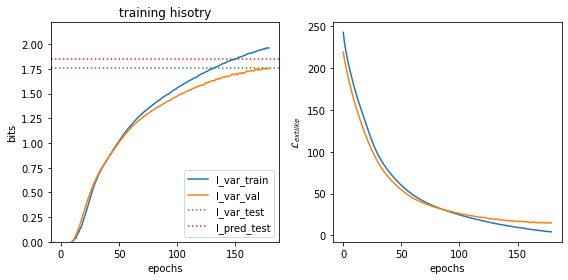

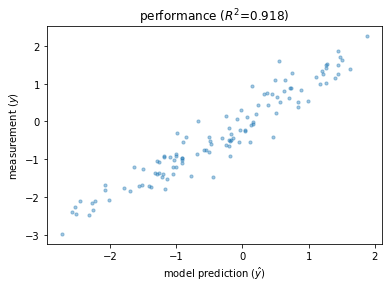

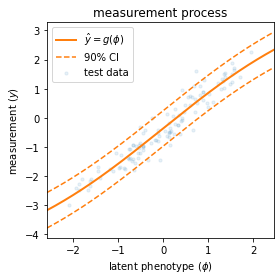

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0141 sec.
Epoch 1/1000
6/6 [==============================] - 0s 26ms/step - loss: 264.7384 - I_var: -0.7065 - val_loss: 229.3556 - val_I_var: -0.3724
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 248.1130 - I_var: -0.5121 - val_loss: 217.4496 - val_I_var: -0.2358
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 235.4763 - I_var: -0.3836 - val_loss: 207.8582 - val_I_var: -0.1562
Epoch 4/1000
6/6 [==============================] - 0s 5ms/step - loss: 225.1839 - I_var: -0.3153 - val_loss: 199.6282 - val_I_var: -0.1055
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 216.6353 - I_var: -0.2641 - val_loss: 192.3905 - val_I_var: -0.0734
Epoch 6/1000
6/6 [==============================] - 0s 5ms/step - loss: 208.9955 - I_var: -0.2361 - val_loss: 185.8013 - val_I_var: -0.0500
Epoch 7/1000
6/6 [=========================

Epoch 59/1000
6/6 [==============================] - 0s 6ms/step - loss: 102.6812 - I_var: -0.1507 - val_loss: 84.2382 - val_I_var: 0.0027
Epoch 60/1000
6/6 [==============================] - 0s 6ms/step - loss: 102.4740 - I_var: -0.1449 - val_loss: 83.8426 - val_I_var: 0.0022
Epoch 61/1000
6/6 [==============================] - 0s 6ms/step - loss: 101.9294 - I_var: -0.1490 - val_loss: 83.4536 - val_I_var: 0.0023
Epoch 62/1000
6/6 [==============================] - 0s 6ms/step - loss: 101.7989 - I_var: -0.1417 - val_loss: 83.0836 - val_I_var: 0.0022
Epoch 63/1000
6/6 [==============================] - 0s 6ms/step - loss: 101.1814 - I_var: -0.1490 - val_loss: 82.7232 - val_I_var: 0.0023
Epoch 64/1000
6/6 [==============================] - 0s 6ms/step - loss: 100.7305 - I_var: -0.1518 - val_loss: 82.3758 - val_I_var: 0.0024
Epoch 65/1000
6/6 [==============================] - 0s 6ms/step - loss: 100.5531 - I_var: -0.1472 - val_loss: 82.0426 - val_I_var: 0.0026
Epoch 66/1000
6/6 [========

6/6 [==============================] - 0s 6ms/step - loss: 92.6474 - I_var: -0.1440 - val_loss: 74.1878 - val_I_var: 0.0020
Epoch 119/1000
6/6 [==============================] - 0s 6ms/step - loss: 92.3115 - I_var: -0.1518 - val_loss: 74.1189 - val_I_var: 0.0021
Epoch 120/1000
6/6 [==============================] - 0s 6ms/step - loss: 92.4431 - I_var: -0.1462 - val_loss: 74.0626 - val_I_var: 0.0020
Epoch 121/1000
6/6 [==============================] - 0s 6ms/step - loss: 92.4278 - I_var: -0.1449 - val_loss: 73.9980 - val_I_var: 0.0021
Epoch 122/1000
6/6 [==============================] - 0s 7ms/step - loss: 92.4966 - I_var: -0.1412 - val_loss: 73.9405 - val_I_var: 0.0022
Epoch 123/1000
6/6 [==============================] - 0s 6ms/step - loss: 92.0791 - I_var: -0.1515 - val_loss: 73.8785 - val_I_var: 0.0023
Epoch 124/1000
6/6 [==============================] - 0s 6ms/step - loss: 92.1523 - I_var: -0.1478 - val_loss: 73.8221 - val_I_var: 0.0022
Epoch 125/1000
6/6 [======================

6/6 [==============================] - 0s 6ms/step - loss: 90.5912 - I_var: -0.1398 - val_loss: 72.0103 - val_I_var: 0.0020
Epoch 178/1000
6/6 [==============================] - 0s 6ms/step - loss: 90.3399 - I_var: -0.1463 - val_loss: 71.9850 - val_I_var: 0.0021
Epoch 179/1000
6/6 [==============================] - 0s 6ms/step - loss: 90.1800 - I_var: -0.1504 - val_loss: 71.9673 - val_I_var: 0.0020
Epoch 180/1000
6/6 [==============================] - 0s 6ms/step - loss: 90.2102 - I_var: -0.1490 - val_loss: 71.9482 - val_I_var: 0.0019
Epoch 181/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.9418 - I_var: -0.1561 - val_loss: 71.9268 - val_I_var: 0.0019
Epoch 182/1000
6/6 [==============================] - 0s 6ms/step - loss: 90.0000 - I_var: -0.1539 - val_loss: 71.9041 - val_I_var: 0.0021
Epoch 183/1000
6/6 [==============================] - 0s 6ms/step - loss: 90.4744 - I_var: -0.1397 - val_loss: 71.8911 - val_I_var: 0.0020
Epoch 184/1000
6/6 [======================

Epoch 236/1000
6/6 [==============================] - 0s 5ms/step - loss: 89.2184 - I_var: -0.1576 - val_loss: 71.2567 - val_I_var: 0.0021
Epoch 237/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.6055 - I_var: -0.1462 - val_loss: 71.2530 - val_I_var: 0.0021
Epoch 238/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.6818 - I_var: -0.1438 - val_loss: 71.2481 - val_I_var: 0.0021
Epoch 239/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.6869 - I_var: -0.1434 - val_loss: 71.2429 - val_I_var: 0.0020
Epoch 240/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.4536 - I_var: -0.1500 - val_loss: 71.2311 - val_I_var: 0.0022
Epoch 241/1000
6/6 [==============================] - 0s 5ms/step - loss: 89.6525 - I_var: -0.1440 - val_loss: 71.2281 - val_I_var: 0.0021
Epoch 242/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.3392 - I_var: -0.1530 - val_loss: 71.2217 - val_I_var: 0.0019
Epoch 243/1000
6/6 [=======

Epoch 295/1000
6/6 [==============================] - 0s 5ms/step - loss: 89.2230 - I_var: -0.1501 - val_loss: 71.0086 - val_I_var: 0.0021
Epoch 296/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.5264 - I_var: -0.1412 - val_loss: 71.0071 - val_I_var: 0.0021
Epoch 297/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.2030 - I_var: -0.1505 - val_loss: 71.0049 - val_I_var: 0.0021
Epoch 298/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.4550 - I_var: -0.1432 - val_loss: 71.0020 - val_I_var: 0.0021
Epoch 299/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.3462 - I_var: -0.1463 - val_loss: 70.9963 - val_I_var: 0.0021
Epoch 300/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.3739 - I_var: -0.1454 - val_loss: 70.9999 - val_I_var: 0.0019
Epoch 301/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.3621 - I_var: -0.1457 - val_loss: 70.9990 - val_I_var: 0.0018
Epoch 302/1000
6/6 [=======

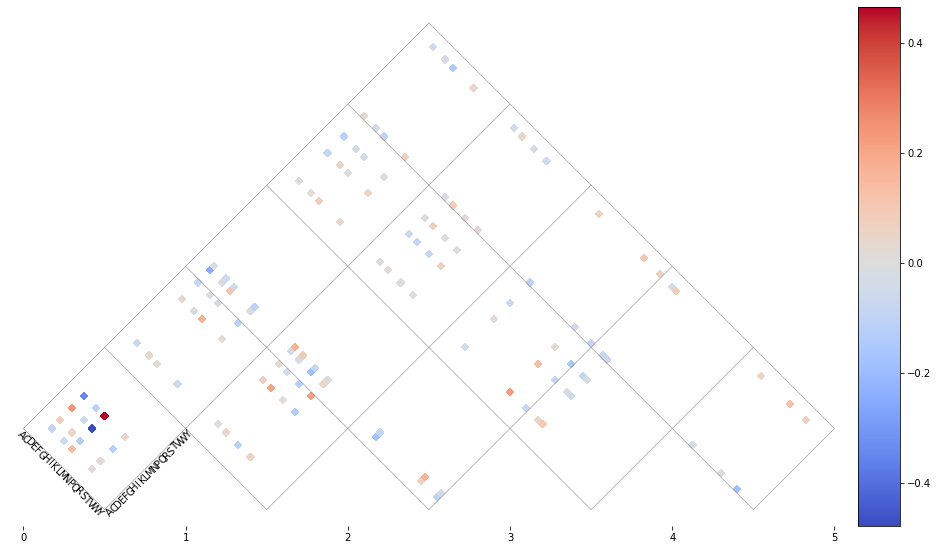

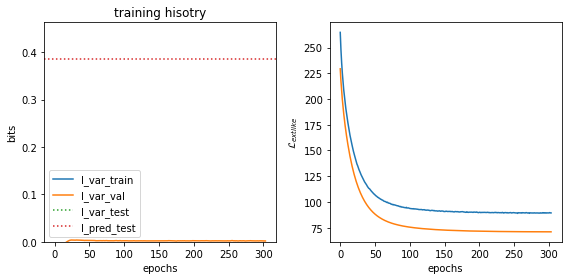

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


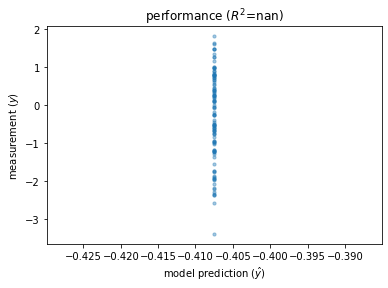

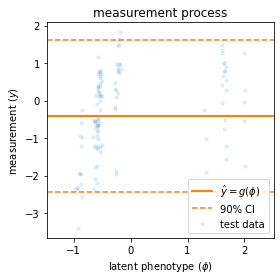

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0139 sec.
Epoch 1/1000
6/6 [==============================] - 0s 26ms/step - loss: 236.3744 - I_var: -0.4011 - val_loss: 195.0535 - val_I_var: -0.2183
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 191.2532 - I_var: -0.0915 - val_loss: 165.7708 - val_I_var: -0.1807
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 165.6751 - I_var: -0.0664 - val_loss: 144.9447 - val_I_var: -0.1753
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 147.7119 - I_var: -0.0538 - val_loss: 129.4510 - val_I_var: -0.1715
Epoch 5/1000
6/6 [==============================] - 0s 5ms/step - loss: 133.5698 - I_var: -0.0398 - val_loss: 116.9647 - val_I_var: -0.1244
Epoch 6/1000
6/6 [==============================] - 0s 6ms/step - loss: 122.4204 - I_var: -0.0120 - val_loss: 106.4802 - val_I_var: -0.0473
Epoch 7/1000
6/6 [=========================

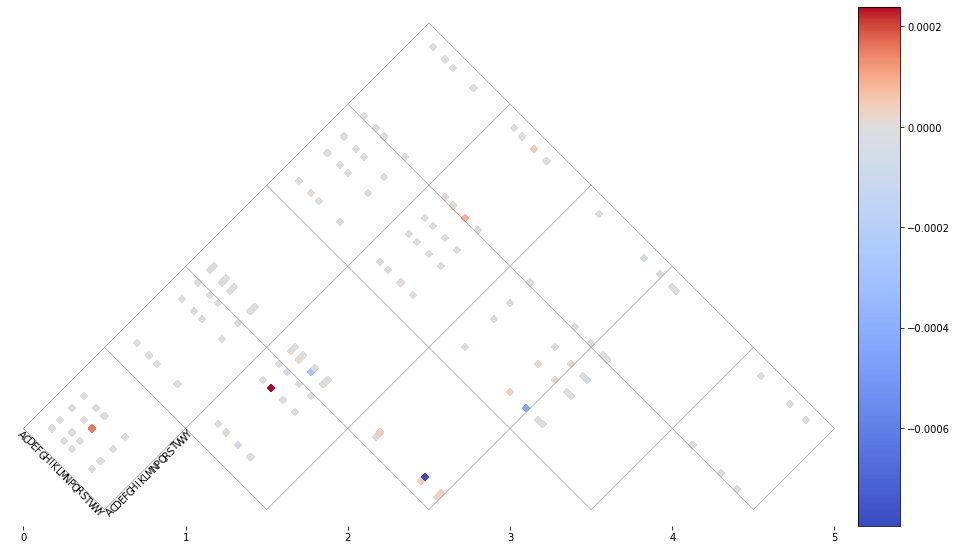

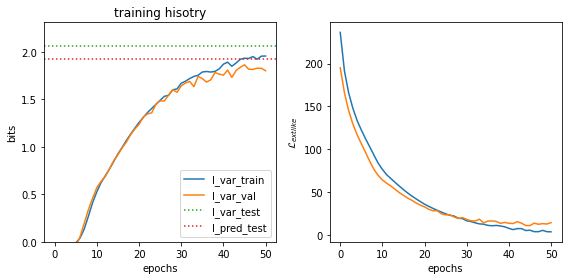

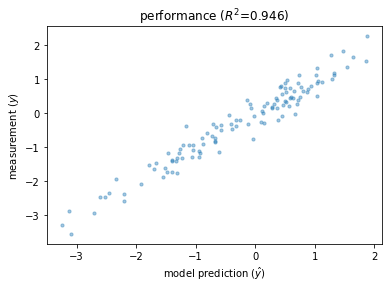

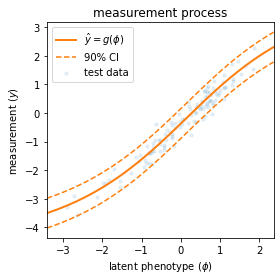

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0149 sec.
Epoch 1/1000
6/6 [==============================] - 0s 27ms/step - loss: 224.0608 - I_var: -0.0384 - val_loss: 191.3692 - val_I_var: -0.0255
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 188.7108 - I_var: 0.0404 - val_loss: 161.2678 - val_I_var: 0.0591
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 160.4865 - I_var: 0.1315 - val_loss: 133.4367 - val_I_var: 0.2572
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 136.3372 - I_var: 0.2771 - val_loss: 114.3917 - val_I_var: 0.3448
Epoch 5/1000
6/6 [==============================] - 0s 5ms/step - loss: 116.6793 - I_var: 0.4076 - val_loss: 100.2137 - val_I_var: 0.4118
Epoch 6/1000
6/6 [==============================] - 0s 6ms/step - loss: 101.9640 - I_var: 0.5186 - val_loss: 89.6860 - val_I_var: 0.4560
Epoch 7/1000
6/6 [==============================] - 0s

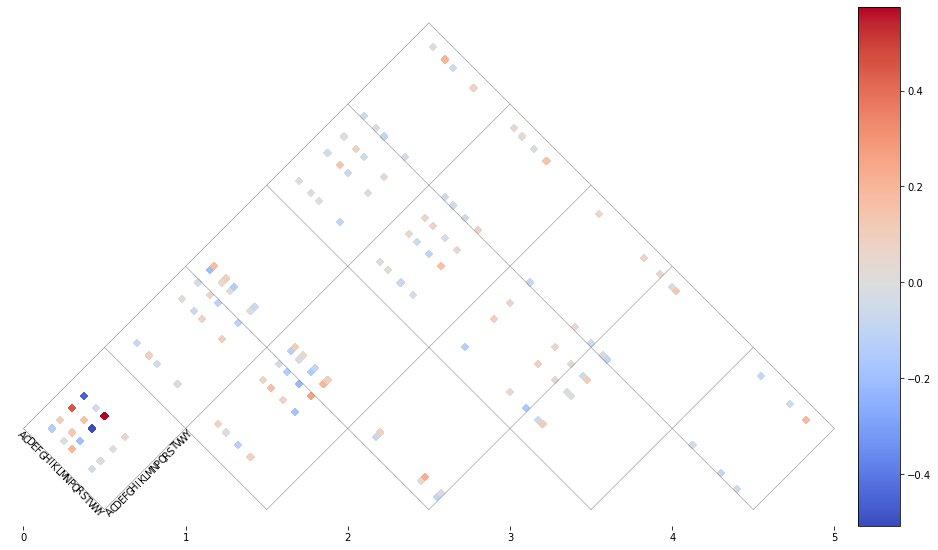

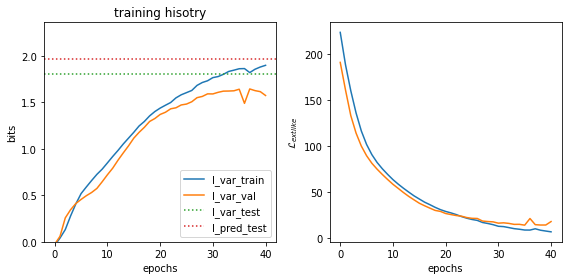

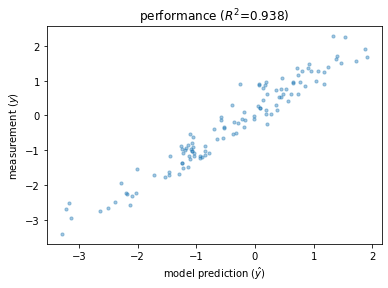

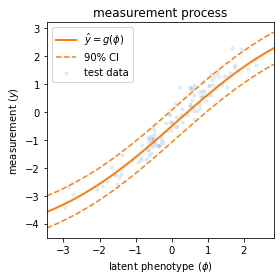

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0154 sec.
Epoch 1/1000
6/6 [==============================] - 0s 26ms/step - loss: 213.3865 - I_var: -0.1439 - val_loss: 162.1136 - val_I_var: -0.0076
Epoch 2/1000
6/6 [==============================] - 0s 5ms/step - loss: 158.3231 - I_var: -0.0286 - val_loss: 124.8976 - val_I_var: 0.0428
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 123.4270 - I_var: 0.1169 - val_loss: 99.0397 - val_I_var: 0.1991
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 98.6049 - I_var: 0.3369 - val_loss: 78.6240 - val_I_var: 0.4475
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 82.1411 - I_var: 0.5154 - val_loss: 68.2354 - val_I_var: 0.5878
Epoch 6/1000
6/6 [==============================] - 0s 5ms/step - loss: 71.9315 - I_var: 0.6485 - val_loss: 60.8376 - val_I_var: 0.6977
Epoch 7/1000
6/6 [==============================] - 0s 6ms/

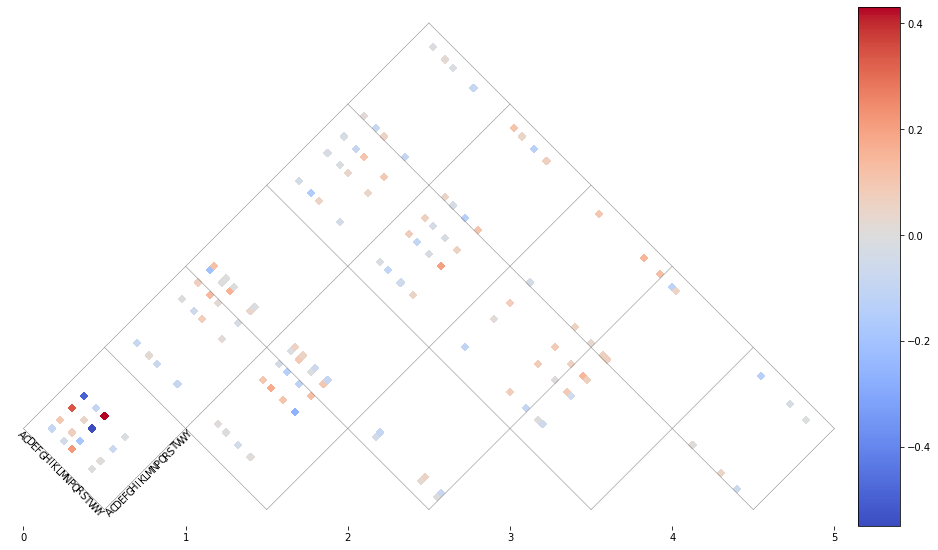

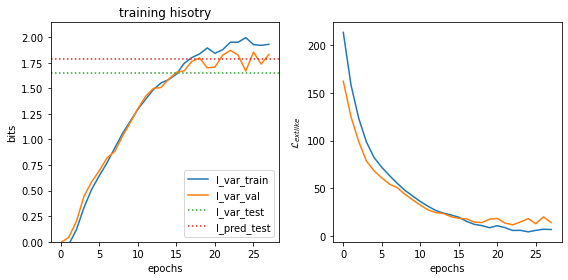

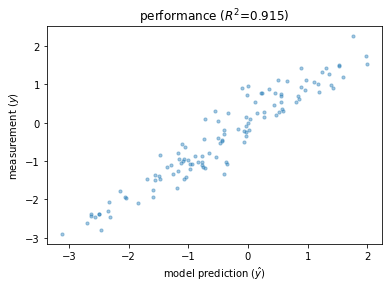

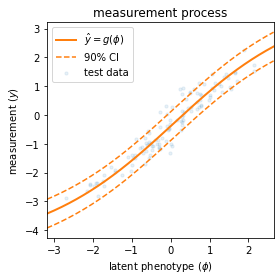

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0127 sec.
Epoch 1/1000
6/6 [==============================] - 0s 26ms/step - loss: 229.3958 - I_var: -0.3051 - val_loss: 166.8391 - val_I_var: 0.0285
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 164.7468 - I_var: -0.0379 - val_loss: 129.7590 - val_I_var: 0.0214
Epoch 3/1000
6/6 [==============================] - 0s 5ms/step - loss: 133.6607 - I_var: -0.0433 - val_loss: 105.7357 - val_I_var: 0.0990
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 112.1773 - I_var: 0.0999 - val_loss: 86.1764 - val_I_var: 0.3150
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 93.1847 - I_var: 0.3150 - val_loss: 73.8383 - val_I_var: 0.4958
Epoch 6/1000
6/6 [==============================] - 0s 6ms/step - loss: 80.4298 - I_var: 0.4961 - val_loss: 66.9801 - val_I_var: 0.5888
Epoch 7/1000
6/6 [==============================] - 0s 5m

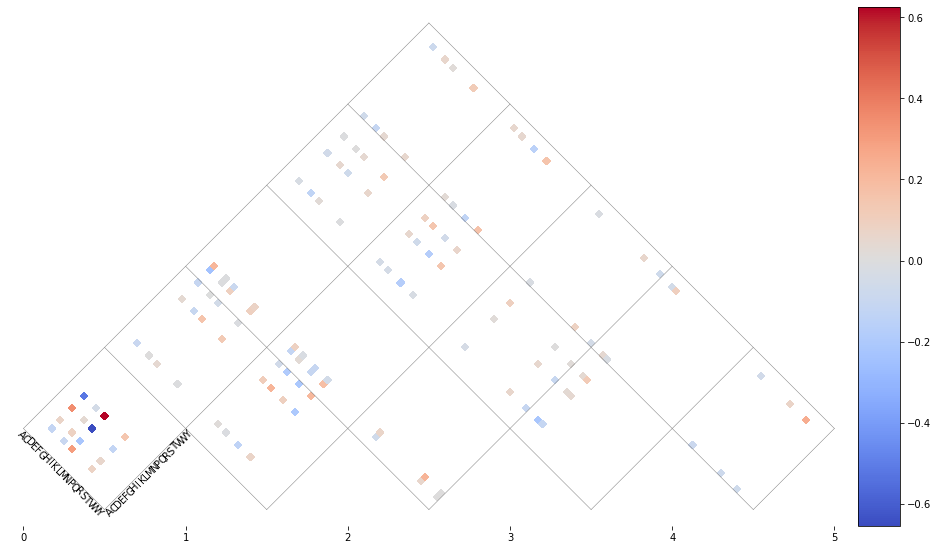

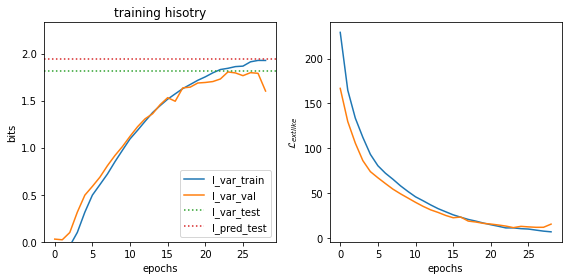

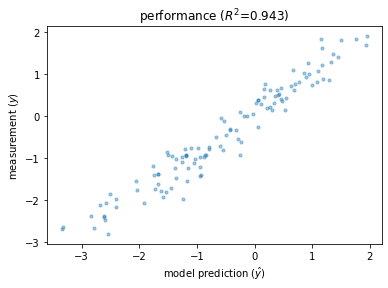

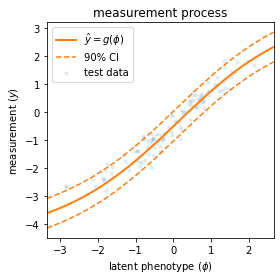

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0139 sec.
Epoch 1/1000
6/6 [==============================] - 0s 27ms/step - loss: 176.1858 - I_var: -0.0677 - val_loss: 93.9868 - val_I_var: 0.3588
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 91.6415 - I_var: 0.4051 - val_loss: 68.2097 - val_I_var: 0.6282
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 70.7566 - I_var: 0.6823 - val_loss: 53.5637 - val_I_var: 0.9304
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 52.0004 - I_var: 1.0245 - val_loss: 39.1246 - val_I_var: 1.2016
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 39.0276 - I_var: 1.2584 - val_loss: 29.9006 - val_I_var: 1.4044
Epoch 6/1000
6/6 [==============================] - 0s 6ms/step - loss: 26.7207 - I_var: 1.5141 - val_loss: 20.7209 - val_I_var: 1.6433
Epoch 7/1000
6/6 [==============================] - 0s 7ms/step -

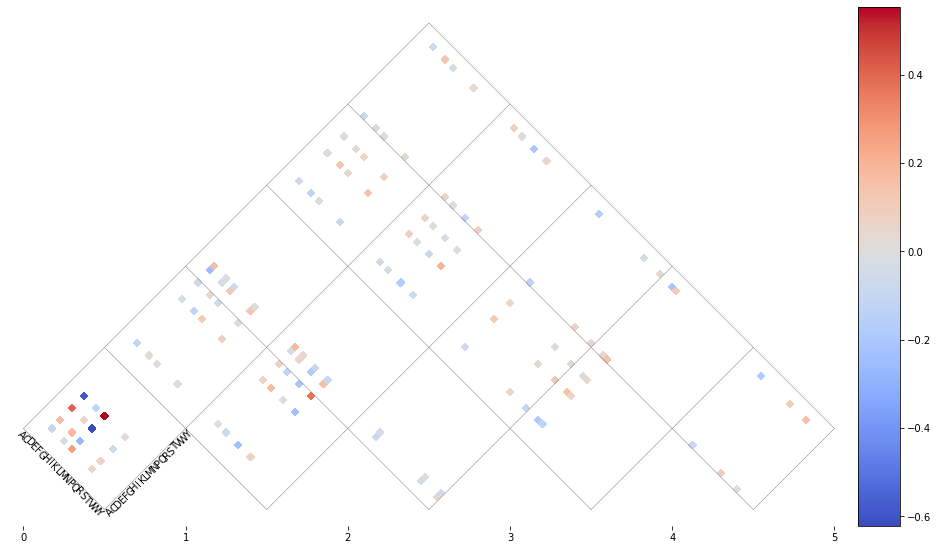

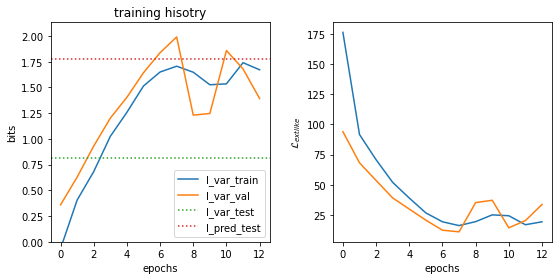

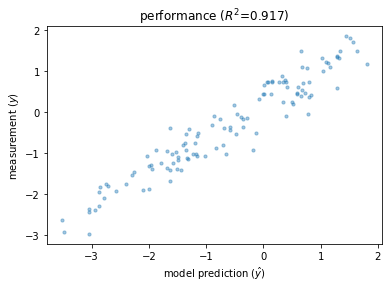

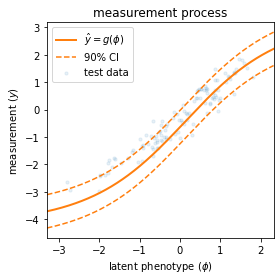

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0156 sec.
Epoch 1/1000
6/6 [==============================] - 0s 26ms/step - loss: 176.8061 - I_var: 0.0376 - val_loss: 94.6423 - val_I_var: 0.4166
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 92.3738 - I_var: 0.4825 - val_loss: 66.2596 - val_I_var: 0.7314
Epoch 3/1000
6/6 [==============================] - 0s 7ms/step - loss: 70.1250 - I_var: 0.7728 - val_loss: 53.7791 - val_I_var: 0.9318
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 53.4338 - I_var: 1.0573 - val_loss: 38.0716 - val_I_var: 1.2558
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 37.5684 - I_var: 1.3397 - val_loss: 26.9112 - val_I_var: 1.4995
Epoch 6/1000
6/6 [==============================] - 0s 5ms/step - loss: 27.5924 - I_var: 1.5285 - val_loss: 23.1545 - val_I_var: 1.6011
Epoch 7/1000
6/6 [==============================] - 0s 6ms/step - 

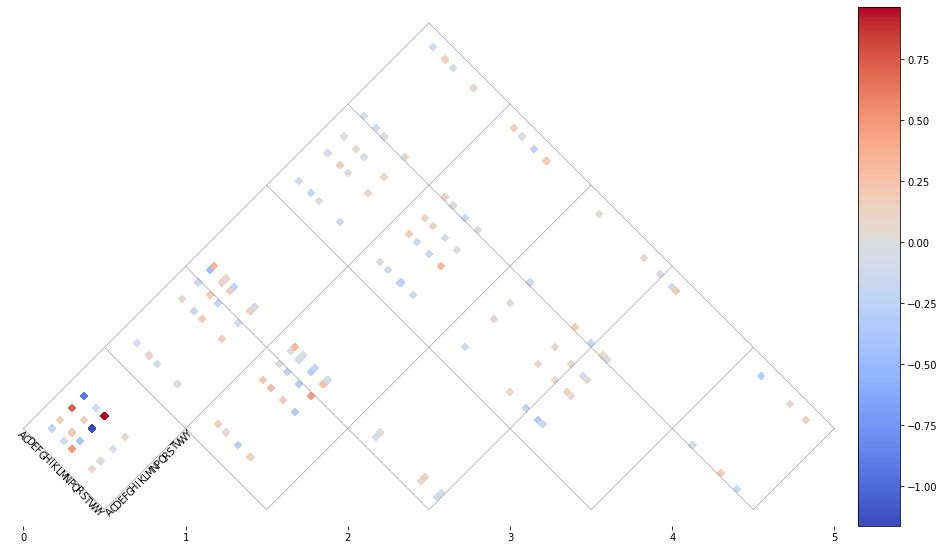

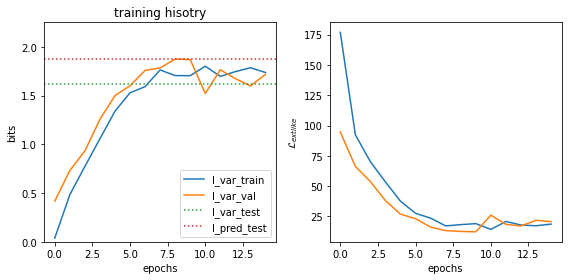

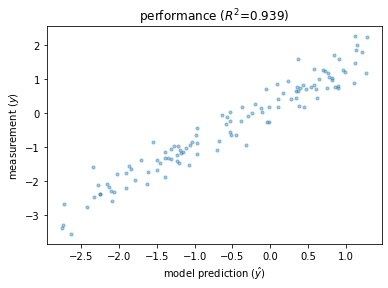

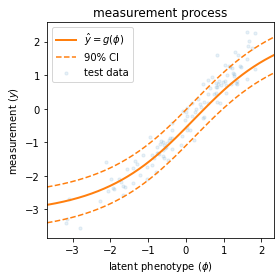

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0131 sec.
Epoch 1/1000
6/6 [==============================] - 0s 27ms/step - loss: 157.8105 - I_var: 0.0143 - val_loss: 83.7826 - val_I_var: 0.3522
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 89.1535 - I_var: 0.4086 - val_loss: 69.9665 - val_I_var: 0.6250
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 69.4510 - I_var: 0.7371 - val_loss: 62.3185 - val_I_var: 0.6077
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 48.5409 - I_var: 1.0976 - val_loss: 37.0307 - val_I_var: 1.2386
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 33.7855 - I_var: 1.3705 - val_loss: 38.1132 - val_I_var: 1.2012
Epoch 6/1000
6/6 [==============================] - 0s 6ms/step - loss: 37.9554 - I_var: 1.2642 - val_loss: 42.8022 - val_I_var: 1.0648
Epoch 7/1000
6/6 [==============================] - 0s 6ms/step - 

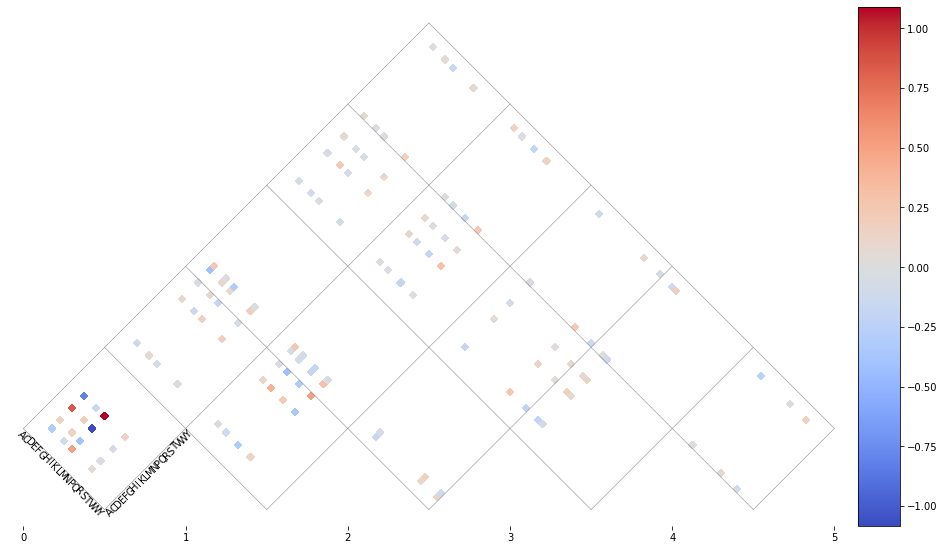

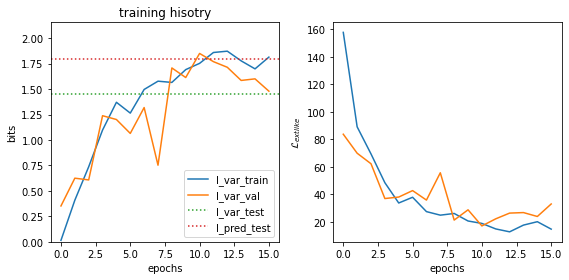

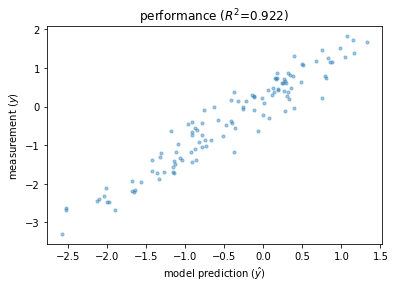

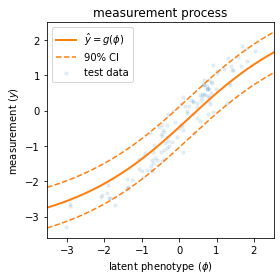

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


N = 460 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0131 sec.
Epoch 1/1000
6/6 [==============================] - 0s 26ms/step - loss: 154.0695 - I_var: 0.0923 - val_loss: 96.9868 - val_I_var: 0.0596
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 87.9404 - I_var: 0.4741 - val_loss: 65.1140 - val_I_var: 0.6971
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 66.4428 - I_var: 0.8268 - val_loss: 45.4794 - val_I_var: 1.0329
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 46.2454 - I_var: 1.1638 - val_loss: 32.0136 - val_I_var: 1.2909
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 38.3466 - I_var: 1.2864 - val_loss: 33.4528 - val_I_var: 1.2103
Epoch 6/1000
6/6 [==============================] - 0s 6ms/step - loss: 29.4682 - I_var: 1.4843 - val_loss: 19.9052 - val_I_var: 1.5197
Epoch 7/1000
6/6 [==============================] - 0s 6ms/step - 

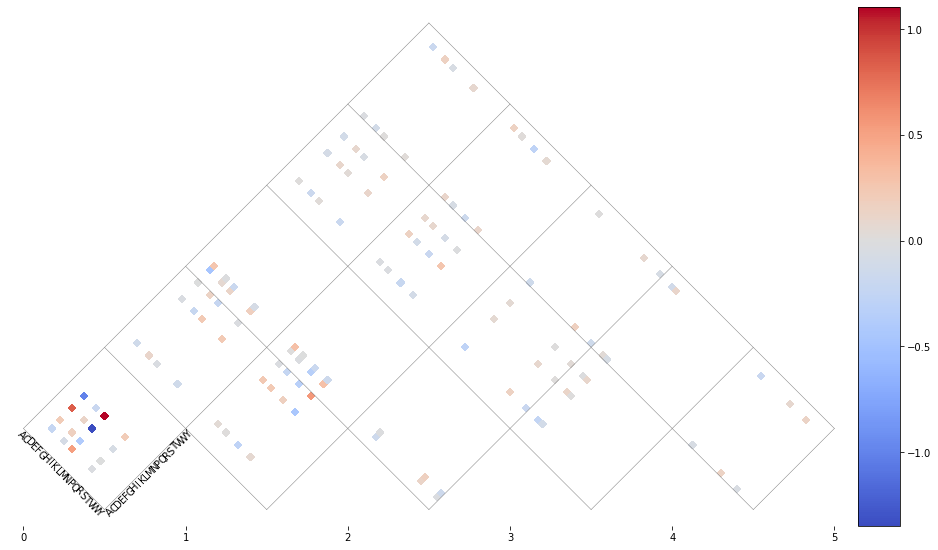

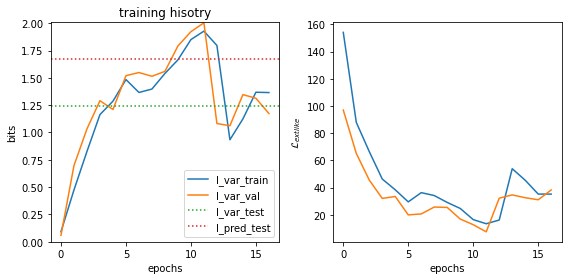

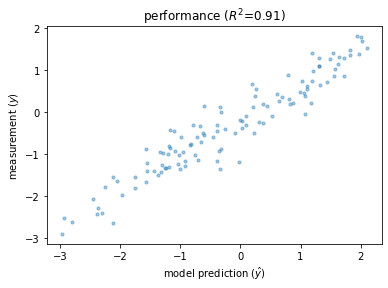

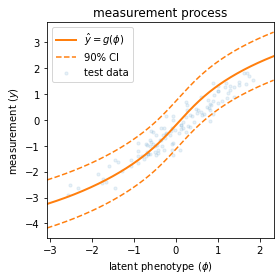

[[-0.10605758]
 [ 0.39633174]
 [-0.34185449]
 [ 0.26003343]
 [ 0.90786826]]
[[-0.05631369]
 [ 0.75840976]
 [ 0.87792531]
 [ 0.95572376]
 [ 0.95908076]]


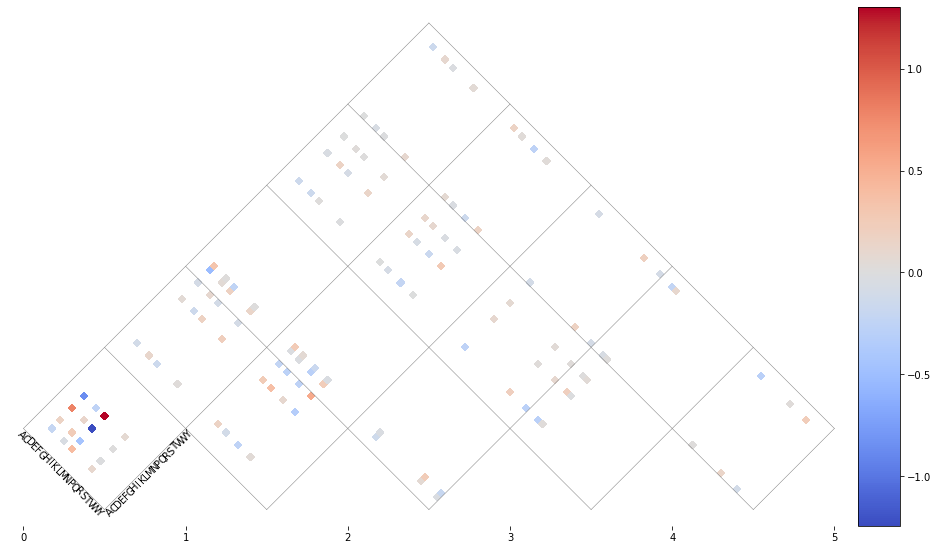

In [8]:
#Find the best regularization for additive fitness(learning rate)
lr_ls=[1e-3,5e-3,1e-2,3e-2,5e-2]
add=np.zeros((5,1))
epi=np.zeros((5,1))
R2=np.zeros((18,2))
R2_epi=np.zeros((133,2))
for lr in lr_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/HA_data_all.csv','HK68') 
        model = Train_model(train_set,test_set,0.8,lr,64)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
        fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
        mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
        data = theta['theta_lclc']
        epi_map=array2df(data)
        epi_map=epi_map.dropna(thresh=3)
        epi_df = df2epimap(epi_map)
        
        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
        R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
    R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = lr_ls.index(lr)
    add[index,0]=R
    epi[index,0]=R_epi
print(add)   
print(epi)

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


     index      ID  InputCount  Rep1Count  Rep2Count  Rep1Fitness  \
0      354  KGYEFA       695.0       85.0      128.0     0.077075   
1      475  QGFEFV       980.0      544.0      408.0     0.349827   
2      300  KESDFA       242.0      599.0      630.0     1.559881   
3      489  QGSENV       218.0     1324.0     1218.0     3.827469   
4      225  HKFENV       604.0      401.0      643.0     0.418396   
..     ...     ...         ...        ...        ...          ...   
455    520  QKSDSA       103.0      134.0      274.0     0.819875   
456    217  HKFDFV       914.0      105.0      155.0     0.072397   
457    381  KKSENV       143.0       57.0       41.0     0.251200   
458     36  EGFDFA       929.0      191.0      269.0     0.129568   
459    164  HESENA       211.0     1299.0     1457.0     3.879778   

     Rep2Fitness   Fitness  Rep1_Preference  Rep2_Preference  Preference  \
0       0.129497  0.103286         0.058620         0.100435    0.079323   
1       0.292731  0

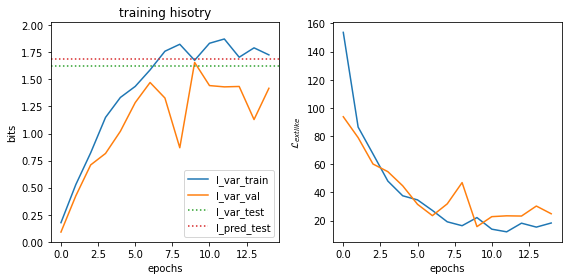

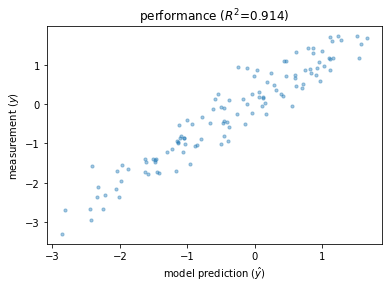

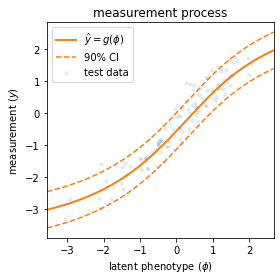

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   E   E -0.301150
1    1.0  2.0   E   G  0.228771
2    1.0  2.0   E   K  0.851969
3    1.0  2.0   E   N -0.880907
4    1.0  2.0   H   E -0.096537
..   ...  ...  ..  ..       ...
128  5.0  6.0   F   V -0.306504
129  5.0  6.0   N   A  0.195313
130  5.0  6.0   N   V  0.121458
131  5.0  6.0   S   A -0.168743
132  5.0  6.0   S   V  0.220957

[133 rows x 5 columns]
    pos aa   add_fit
0   156  E -0.283420
1   156  H -0.010748
2   156  K -0.074619
3   156  Q  0.024492
4   158  E  0.302847
5   158  G -0.094637
6   158  K -0.657815
7   158  N  0.022161
8   159  F -0.124726
9   159  S  0.527005
10  159  Y -0.037384
11  190  D -0.124539
12  190  E  0.269295
13  193  F -0.199241
14  193  N  0.204124
15  193  S  0.243369
16  196  A -0.164997
17  196  V -0.049729


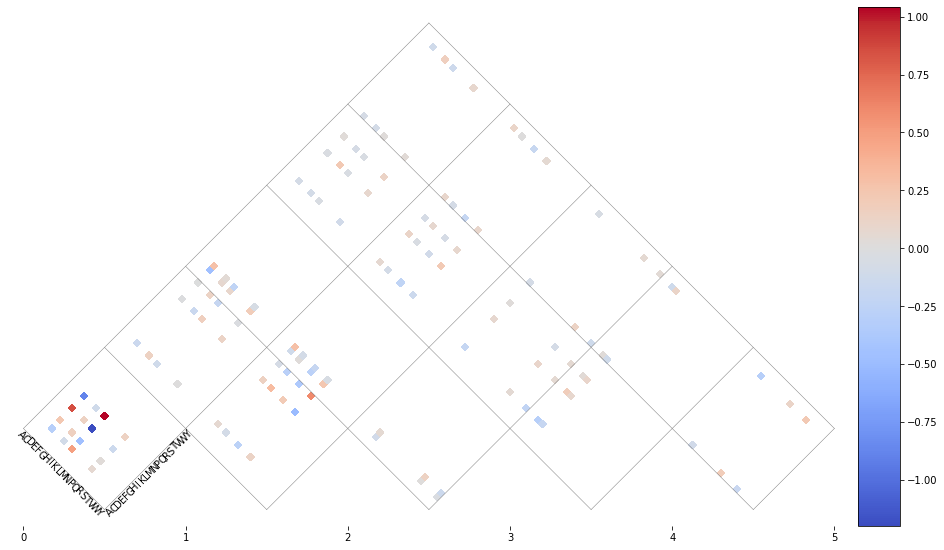

In [6]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/HA_data_all.csv','HK68')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
#model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HA_HK68_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HA_HK68_add.csv')
print(add_df)

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


     index      ID  InputCount  Rep1Count  Rep2Count  Rep1Fitness  \
0     1104  QKYDFA       341.0        1.0        6.0     0.002441   
1      611  EEYESV       495.0     9242.0     5084.0    15.539393   
2      759  HGFDNV       857.0       99.0       87.0     0.096145   
3     1002  KNYEFA       587.0       11.0        4.0     0.015597   
4      851  HNSESV       494.0      522.0      736.0     0.879461   
..     ...     ...         ...        ...        ...          ...   
455    749  HEYDSV       404.0      148.0      187.0     0.304897   
456    578  EEFDNA       710.0      561.0      690.0     0.657624   
457    917  KGSDSV       359.0        8.0        9.0     0.018547   
458    919  KGSEFV       332.0        3.0        6.0     0.007521   
459    726  HEFEFA       966.0     1351.0     1912.0     1.163996   

     Rep2Fitness    Fitness  Rep1_Preference  Rep2_Preference  Preference  \
0       0.012731   0.007586         0.002462         0.012677    0.007603   
1       7.431102 

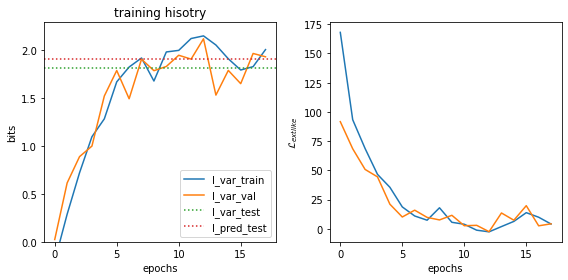

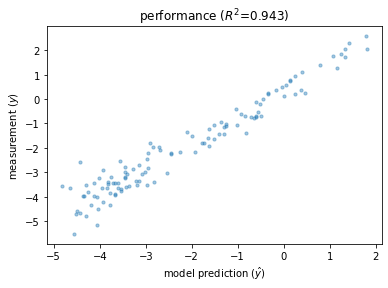

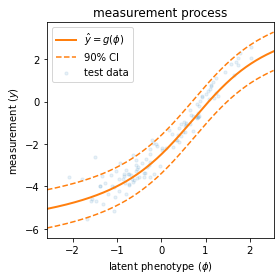

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   E   E -0.105356
1    1.0  2.0   E   G  0.275659
2    1.0  2.0   E   K -0.155400
3    1.0  2.0   E   N  0.300410
4    1.0  2.0   H   E  0.361395
..   ...  ...  ..  ..       ...
128  5.0  6.0   F   V -0.415441
129  5.0  6.0   N   A -0.046911
130  5.0  6.0   N   V  0.169045
131  5.0  6.0   S   A -0.095937
132  5.0  6.0   S   V  0.160359

[133 rows x 5 columns]
    pos aa   add_fit
0   156  E  0.420991
1   156  H  0.075428
2   156  K -0.740048
3   156  Q  0.116690
4   158  E  0.540644
5   158  G -0.097274
6   158  K -0.700612
7   158  N  0.100278
8   159  F -0.108358
9   159  S  0.152806
10  159  Y -0.323726
11  190  D  0.082926
12  190  E -0.057873
13  193  F -0.346897
14  193  N  0.010292
15  193  S  0.077282
16  196  A -0.033506
17  196  V -0.144370


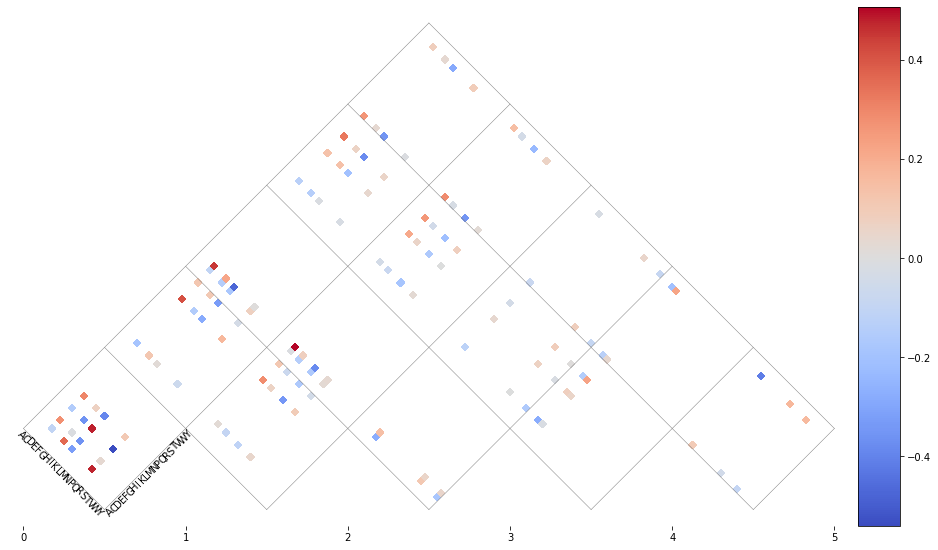

In [9]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/HA_data_all.csv','Bk79')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
#model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HA_Bk79_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HA_Bk79_add.csv')
print(add_df)

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


     index      ID  InputCount  Rep1Count  Rep2Count  Rep1Fitness  \
0     1652  QGYENA       318.0       86.0      114.0     0.172302   
1     1465  KEYDFV       179.0        8.0        7.0     0.028475   
2     1277  ENSDSV       444.0      635.0      618.0     0.911193   
3     1460  KESENA       352.0      350.0      275.0     0.633498   
4     1271  ENFESV       838.0     3200.0     3005.0     2.432907   
..     ...     ...         ...        ...        ...          ...   
455   1493  KGSDSV       261.0       29.0       18.0     0.070791   
456   1449  KEFENV       435.0      202.0      166.0     0.295857   
457   1467  KEYDNV       169.0        3.0       21.0     0.011310   
458   1710  QNSEFA       362.0      207.0      157.0     0.364319   
459   1311  HESDNV       203.0      301.0      463.0     0.944692   

     Rep2Fitness   Fitness  Rep1_Preference  Rep2_Preference  Preference  \
0       0.266803  0.219552         0.202625         0.303006    0.253690   
1       0.029104  0

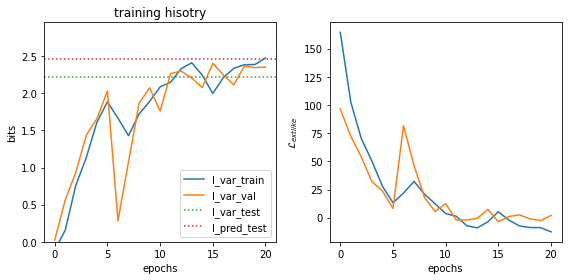

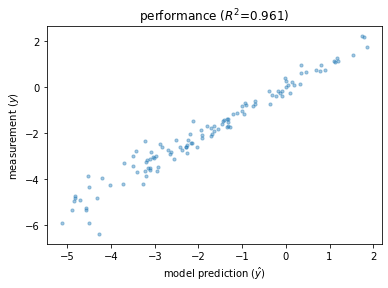

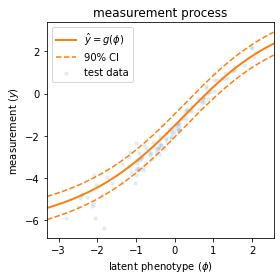

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   E   E -0.406504
1    1.0  2.0   E   G  0.185086
2    1.0  2.0   E   K  0.227097
3    1.0  2.0   E   N  0.213089
4    1.0  2.0   H   E  0.462123
..   ...  ...  ..  ..       ...
128  5.0  6.0   F   V -0.318089
129  5.0  6.0   N   A  0.019831
130  5.0  6.0   N   V  0.064650
131  5.0  6.0   S   A -0.010037
132  5.0  6.0   S   V  0.164840

[133 rows x 5 columns]
    pos aa   add_fit
0   156  E  0.345328
1   156  H  0.321486
2   156  K -0.542455
3   156  Q  0.088598
4   158  E  0.660843
5   158  G  0.036744
6   158  K -0.652951
7   158  N  0.113309
8   159  F  0.026424
9   159  S  0.290596
10  159  Y -0.206397
11  190  D -0.125159
12  190  E  0.031494
13  193  F -0.250040
14  193  N  0.083056
15  193  S  0.118276
16  196  A  0.097909
17  196  V -0.020357


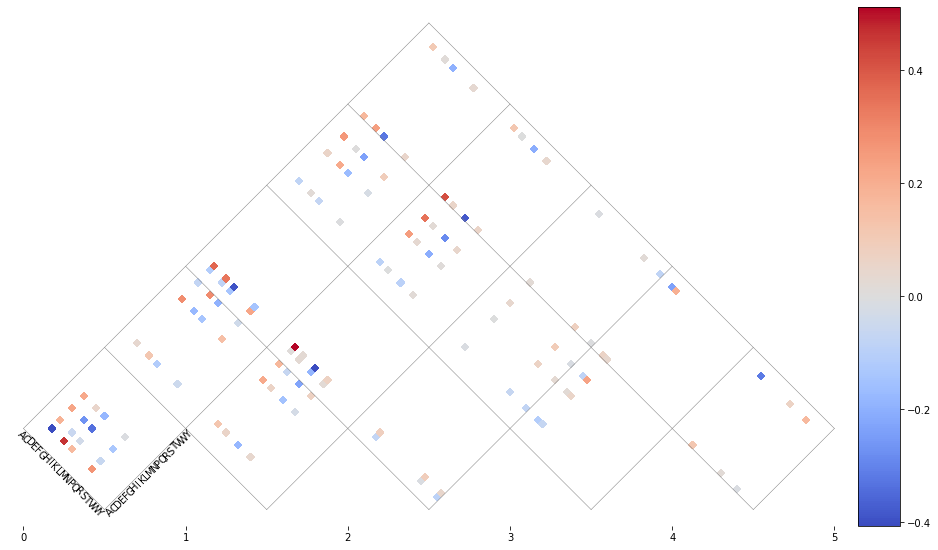

In [10]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/HA_data_all.csv','Bei89')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
#model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HA_Bei89_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HA_Bei89_add.csv')
print(add_df)

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


     index      ID  InputCount  Rep1Count  Rep2Count  Rep1Fitness  \
0     3303  ENFDFA         988        523        932     0.536919   
1     2980  EKFEFA         546          1         28     0.001858   
2     3280  EKSDSV         551        226        304     0.416026   
3     3225  HNYESV         309         49         88     0.160843   
4     3105  KNYESV         400         28         46     0.071001   
..     ...     ...         ...        ...        ...          ...   
455   3023  HESEFA         364          3         30     0.008360   
456   2919  KNFEFV         530          5          3     0.009569   
457   2998  KGYDFV         856         20         30     0.023698   
458   2907  KKFDNV         757          2          4     0.002680   
459   2958  KNFDFV         889          8         24     0.009128   

     Rep2Fitness   Fitness  Rep1_Preference  Rep2_Preference  Preference  \
0       0.749187  0.643053         0.546441         0.752274    0.650051   
1       0.040728  0

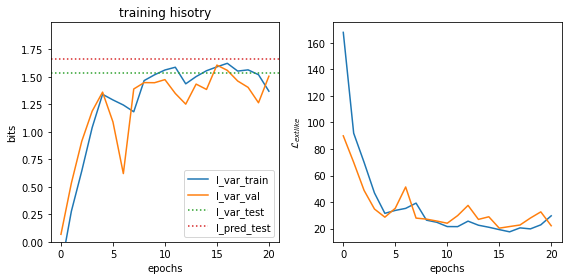

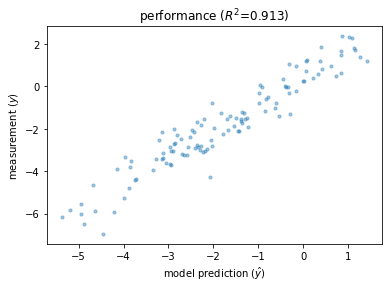

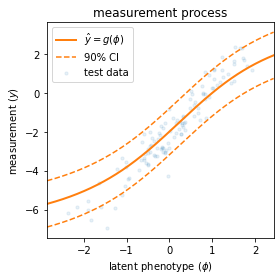

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   E   E -0.410470
1    1.0  2.0   E   G -0.128094
2    1.0  2.0   E   K  0.484527
3    1.0  2.0   E   N -0.016328
4    1.0  2.0   H   E -0.128081
..   ...  ...  ..  ..       ...
128  5.0  6.0   F   V -0.341784
129  5.0  6.0   N   A  0.053968
130  5.0  6.0   N   V  0.186925
131  5.0  6.0   S   A -0.053593
132  5.0  6.0   S   V  0.174946

[133 rows x 5 columns]
    pos aa   add_fit
0   156  E -0.056160
1   156  H -0.027705
2   156  K -0.290257
3   156  Q  0.394100
4   158  E  0.251349
5   158  G  0.159580
6   158  K -0.344369
7   158  N  0.208730
8   159  F -0.003578
9   159  S  0.166240
10  159  Y  0.024034
11  190  D  0.339768
12  190  E -0.122188
13  193  F -0.290639
14  193  N  0.080473
15  193  S  0.030181
16  196  A -0.083893
17  196  V  0.035944


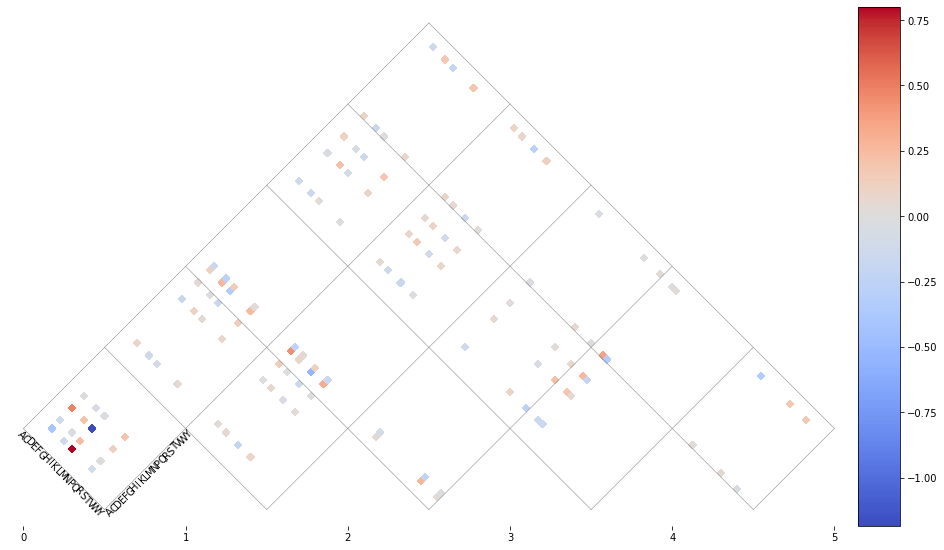

In [12]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/HA_data_all.csv','Mos99')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
#model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HA_Mos99_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HA_Mos99_add.csv')
print(add_df)

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


     index      ID  InputCount  Rep1Count  Rep2Count  Rep1Fitness  \
0     1612  KGYDNV         429        351        173     0.713851   
1     1484  QGYESV         500         58         14     0.101208   
2     1620  HEYDNV         335        263        247     0.684966   
3     1356  EKFENV         679         24         26     0.030839   
4     1164  EKFEFV         777          5          7     0.005614   
..     ...     ...         ...        ...        ...          ...   
455   1381  EKSDSV         293         20          5     0.059555   
456   1221  EESEFA         530         12          6     0.019754   
457   1340  KGFENA         773         29         22     0.032732   
458   1667  QEFDSA         340       1271        482     3.261553   
459   1355  KEYENA         598         21         22     0.030639   

     Rep2Fitness   Fitness  Rep1_Preference  Rep2_Preference  Preference  \
0       0.373632  0.543741         0.595830         0.308828    0.451628   
1       0.025943  0

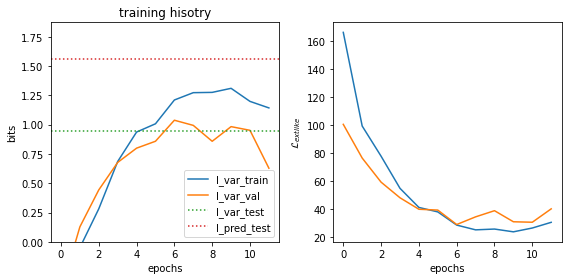

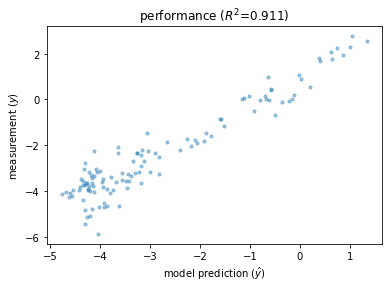

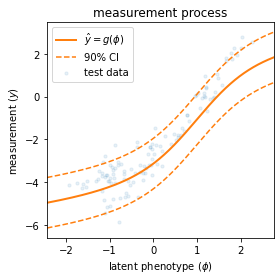

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   E   E -0.059662
1    1.0  2.0   E   G -0.081389
2    1.0  2.0   E   K  0.037015
3    1.0  2.0   E   N -0.109747
4    1.0  2.0   H   E -0.039267
..   ...  ...  ..  ..       ...
128  5.0  6.0   F   V -0.496492
129  5.0  6.0   N   A -0.324020
130  5.0  6.0   N   V  0.269616
131  5.0  6.0   S   A  0.016961
132  5.0  6.0   S   V  0.003349

[133 rows x 5 columns]
    pos aa   add_fit
0   156  E -0.216323
1   156  H  0.198251
2   156  K  0.007043
3   156  Q  0.107673
4   158  E -0.123353
5   158  G  0.038331
6   158  K -0.059914
7   158  N  0.050983
8   159  F -0.100009
9   159  S -0.448569
10  159  Y  0.041526
11  190  D  0.269474
12  190  E -0.425886
13  193  F -0.079114
14  193  N -0.031783
15  193  S  0.056000
16  196  A -0.016554
17  196  V -0.015213


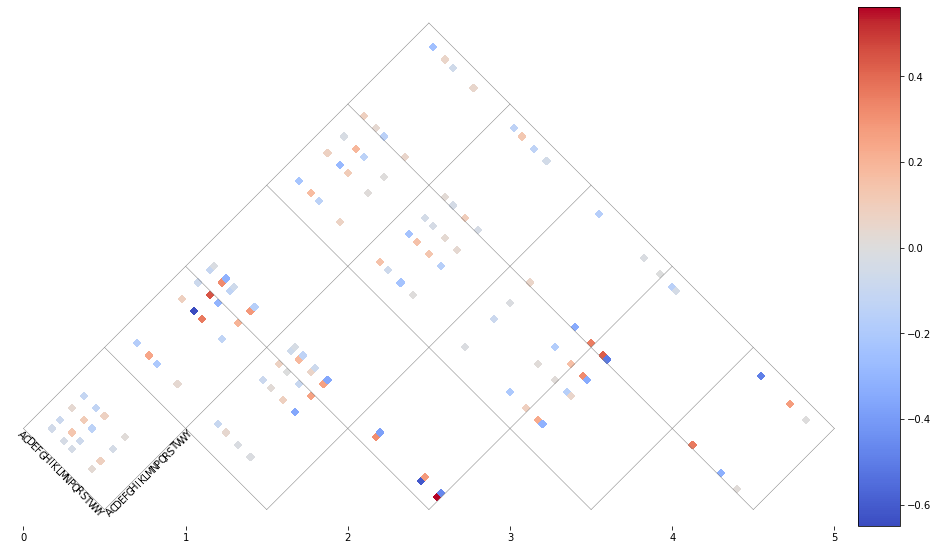

In [13]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/HA_data_all.csv','Bris07L194')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
#model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HA_Bris07_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HA_Bris07_add.csv')
print(add_df)

<ipython-input-5-005e674350ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['Fitness'])


     index      ID  InputCount  Rep1Count  Rep2Count  Rep1Fitness  \
0     3827  HNYENV         523        416        404     0.630067   
1     3961  QNYDSV         288        902        973     2.480899   
2     4014  QNSDFA         222       1346       1943     4.802719   
3     3595  KEYENV         406        144         59     0.280952   
4     3765  ENFDFA         762        560        314     0.582141   
..     ...     ...         ...        ...        ...          ...   
455   3724  EEYENA         560        304        231     0.430012   
456   3997  QNFDSA         553       2735       3278     3.917665   
457   3886  HEFDFA         677       1106        709     1.294081   
458   3704  EKYENA         574        272        239     0.375364   
459   3839  QKFDNV         274        261        200     0.754545   

     Rep2Fitness   Fitness  Rep1_Preference  Rep2_Preference  Preference  \
0       0.623003  0.626535         0.574244         0.541879    0.557683   
1       2.724777  2

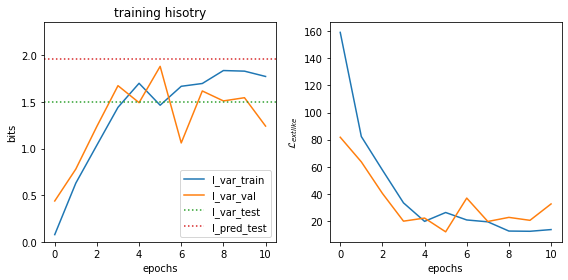

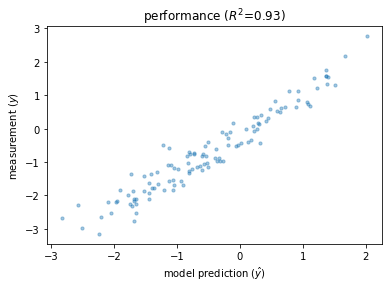

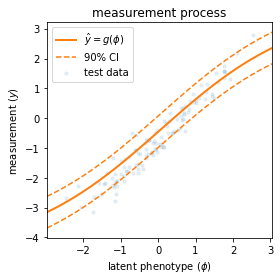

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   E   E -0.345388
1    1.0  2.0   E   G -0.063521
2    1.0  2.0   E   K  0.173665
3    1.0  2.0   E   N -0.039309
4    1.0  2.0   H   E -0.000267
..   ...  ...  ..  ..       ...
128  5.0  6.0   F   V -0.437116
129  5.0  6.0   N   A  0.082999
130  5.0  6.0   N   V  0.184642
131  5.0  6.0   S   A -0.022248
132  5.0  6.0   S   V  0.285040

[133 rows x 5 columns]
    pos aa   add_fit
0   156  E -0.024083
1   156  H  0.177852
2   156  K -0.267446
3   156  Q  0.369821
4   158  E  0.135236
5   158  G -0.004240
6   158  K -0.268190
7   158  N  0.205210
8   159  F -0.014987
9   159  S  0.274891
10  159  Y -0.028014
11  190  D  0.249806
12  190  E -0.645600
13  193  F -0.247519
14  193  N  0.421787
15  193  S  0.188136
16  196  A  0.283244
17  196  V -0.307274


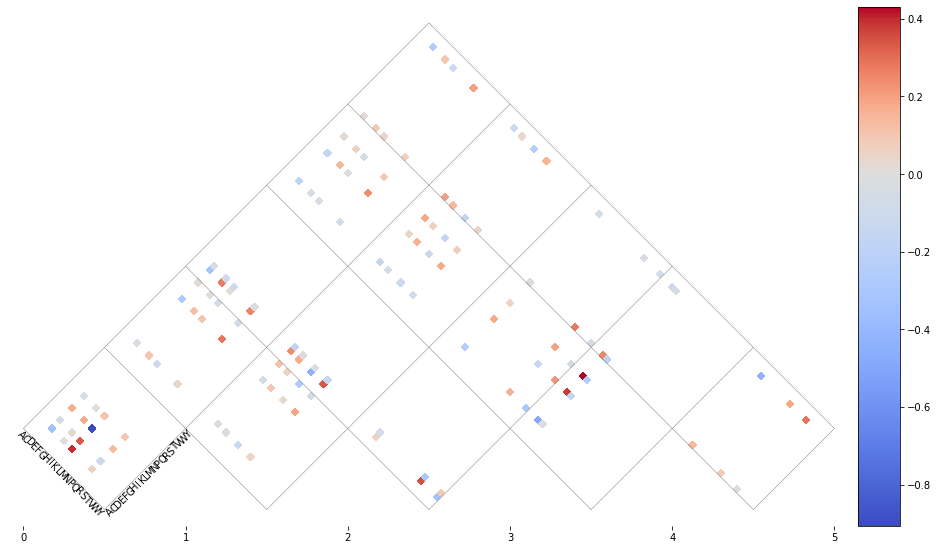

In [14]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/HA_data_all.csv','NDako16')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
#model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HA_NDako16_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HA_NDako16_add.csv')
print(add_df)